1 files found:
  - 112727.lvm
Loading 112727.lvm...
  Time resolution: avg=0.200000s, min=0.200000s, max=0.200000s
  Sampling rate: 5.00 Hz

Processing Shot 112727
Global trigger time detected at: 13.800 seconds

=== ΔT Summary (with heating event detection) ===
T1 = Baseline Temperature (3s avg, 2s before trigger), T2 = Heated Temperature (3s avg, 2s after trigger), ΔT = Temperature Rise (°C)
Analyzing 12 AI(s): AI 32, AI 33, AI 34, AI 35, AI 36, AI 38, AI 39, AI 40, AI 41, AI 42, AI 43, AI 44
Label  T1 (°C)  T2 (°C)  ΔT (°C)  trigger_t (s)  t1_min (s)  t1_max (s)  t2_min (s)  t2_max (s)
AI 32   35.883   35.967    0.085         13.800       8.800      11.800      15.800      18.800
AI 33   36.247   36.407    0.160         13.800       8.800      11.800      15.800      18.800
AI 34   35.899   36.029    0.130         13.800       8.800      11.800      15.800      18.800
AI 35   36.372   36.457    0.085         13.800       8.800      11.800      15.800      18.800
AI 36   36.440   36.

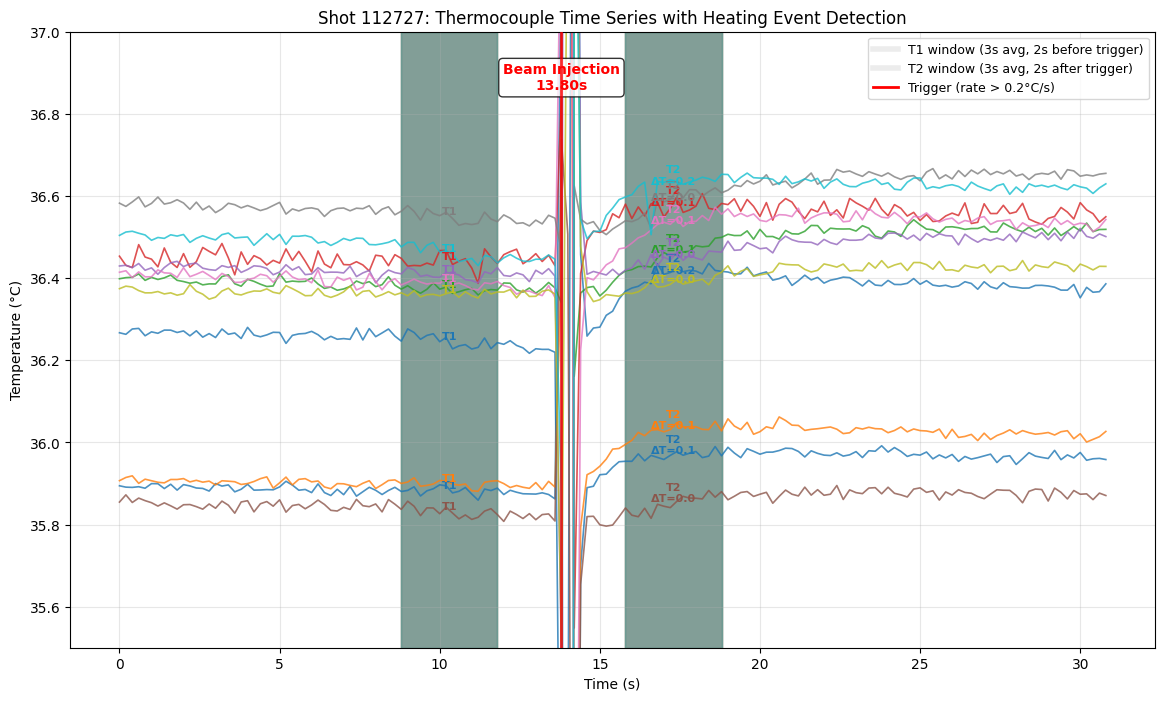


SUMMARY: Processed 1 shots successfully

=== Average ΔT Across All Shots ===
       mean  std  count
Label                  
AI 44 0.315  NaN      1
AI 43 0.163  NaN      1
AI 33 0.160  NaN      1
AI 40 0.141  NaN      1
AI 36 0.133  NaN      1
AI 34 0.130  NaN      1
AI 35 0.085  NaN      1
AI 32 0.085  NaN      1
AI 38 0.038  NaN      1
AI 41 0.035  NaN      1
AI 42 0.025  NaN      1
AI 39 0.020  NaN      1


In [39]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit

# ================== USER SETTINGS ==================
# where the thermocouple data lives
BASE_FOLDER = Path("/p/ltxdata/thermocouple/LTXB")

# put shot numbers here, leave empty to load all files
shotlist = [ 112727
    
]

SELECTED_TCS = None 
#   SELECTED_TCS = [1, 7, 12]
#   SELECTED_TCS = [7]

# heating event detection (replaced the fixed time windows)
# This approach automatically detects heating events by finding when |dT/dt| > threshold of 0.2 or whatever you want to set it to
# T1 (baseline) = 3-second average taken 2 seconds before the trigger
# T2 (post beam) = 3-second average taken 2 seconds after the trigger
RATE_THRESHOLD = 0.2  # °C/s threshold for detecting significant heating events (beam impact)

# Y-axis range for temperature plots (set to None for automatic scaling)
#Y_AXIS_RANGE = None
Y_AXIS_RANGE = (35.5, 37)

# Grid coordinates for thermocouples (inches, 8×6 plate, 2×2 squares)
# centers at x = 0.5/2.5/4.5/6.5/… as you laid out
"""
TC_POSITIONS = {
    "Beam Dump TC#1":  (0.5, -1),
    "Beam Dump TC#2":  (3.5, -1),
    "Beam Dump TC#3":  (4.5, -1),
    "Beam Dump TC#4":  (7.5, -1),
    "Beam Dump TC#5":  (1.5, -3),
    "Beam Dump TC#6":  (2.5, -3),
    "Beam Dump TC#7":  (5.5, -3),
    "Beam Dump TC#8":  (6.5, -3),
    "Beam Dump TC#9":  (1.75, -5),
    "Beam Dump TC#10": (2.25, -5),
    "Beam Dump TC#11": (5.75, -5),
    "Beam Dump TC#12": (6.25, -5),
}
"""

TC_POSITIONS = {
    "AI 32":  (1, -1),
    "AI 33":  (3, -1),
    "AI 34":  (5, -1),
    "AI 35":  (7, -1),
    "AI 36":  (1, -3),
    "AI 39":  (3, -3),
    "AI 42":  (5, -3),
    "AI 38":  (7, -3),
    "AI 41":  (1, -5),
    "AI 44": (3, -5),
    "AI 43": (5, -5),
    "AI 40": (7, -5),
}
# Mapping of LVM column indices to labels
"""TEMP_TO_LABEL = {

    32: "Beam Dump TC#1",  33: "Beam Dump TC#2",  34: "Beam Dump TC#5",
    35: "Beam Dump TC#3",  36: "Beam Dump TC#4",  37: "Beam Dump TC#7",
    38: "Beam Dump TC#10", 39: "Beam Dump TC#6",  40: "Beam Dump TC#9",
    41: "Beam Dump TC#12", 42: "Beam Dump TC#11", 43: "Beam Dump TC#8",}"""

TEMP_TO_LABEL = {
    32: "AI 32",  33: "AI 33",  34: "AI 34",
    35: "AI 35",  36: "AI 36",  39: "AI 39",
    42: "AI 42",  38: "AI 38",  41: "AI 41",
    44: "AI 44",  43: "AI 43",  40: "AI 40"
}
# ====================================================

def find_data_start(path) -> int:
    """LVM files have a header, need to find where the actual data starts"""
    end_idx = -1
    with open(path, "r", errors="replace") as f:
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end_idx = i
    if end_idx == -1:
        raise RuntimeError("***End_of_Header*** not found in file check how you are parsing through it.")
    return end_idx + 1

def window_mask(tvec, a, b):
    return (tvec >= a) & (tvec <= b)

def window_mean(arr, tvec, a, b):
    m = window_mask(tvec, a, b)
    return float(np.mean(arr[m])) if np.any(m) else np.nan

#Find global trigger time when beam actually hits and TCs start ramping up. ↓↓↓↓ default float value gets ignored if rate_threshold variable is changed above
def find_global_trigger(time: np.ndarray, all_tc_data: dict, rate_threshold: float = 0.5):

    time_series = pd.Series(time)
    
    # Look for sustained heating across multiple TCs
    aggregate_rate = pd.Series(0.0, index=time_series.index) #sum of all heating rates across Tcs
    tc_count_heating = pd.Series(0, index=time_series.index) #finding which tcs are heating up
    
    for tc_data in all_tc_data.values():
        temp_series = pd.Series(tc_data)
        temp_series = pd.to_numeric(temp_series, errors='coerce')
        
        # Calculating heating rate (°C/s) at each time point and counts how many TCs exceed the threshold rate 
        dtemp = temp_series.diff()
        dt = time_series.diff()
        with np.errstate(divide='ignore', invalid='ignore'):
            rate = dtemp / dt
        
        # Only consider significant positive heating rates
        significant_heating = rate > rate_threshold
        tc_count_heating += significant_heating.astype(int)
        
        # Add to aggregate (only positive rates)
        positive_rate = rate.clip(lower=0)
        aggregate_rate += positive_rate.fillna(0)
    
    # Require multiple TCs to be heating simultaneously (at least 3 TCs)
    min_tcs_heating = max(3, len(all_tc_data) // 3)
    simultaneous_heating = tc_count_heating >= min_tcs_heating
    
    # Also require aggregate rate to be significant and calculates the minimum total heating rate expected
    strong_heating = aggregate_rate > (rate_threshold * min_tcs_heating)
    
    # Combine both conditions
    trigger_condition = simultaneous_heating & strong_heating
    
    if not trigger_condition.any():
        # Fallback: look for any significant aggregate heating
        fallback_condition = aggregate_rate > (rate_threshold * 2)
        if not fallback_condition.any():
            return None
        trigger_idx = fallback_condition[fallback_condition].index[0]
    else:
        trigger_idx = trigger_condition[trigger_condition].index[0]
    
    return float(time_series.iloc[trigger_idx])

def detect_heating_event(time: np.ndarray, temp: np.ndarray, rate_threshold: float = 0.5):
    """Detect heating event by finding when temperature rate exceeds threshold.
    
    Args:
        time: Time array
        temp: Temperature array
        rate_threshold: Threshold for heating rate (°C/s), default 0.5
        
    Returns:
        trigger_time: Time when heating event detected, or None if not found
    """
    time_series = pd.Series(time)
    temp_series = pd.Series(pd.to_numeric(temp, errors='coerce'))
    
    # Calculate temperature rate of change
    dtemp = temp_series.diff()
    dt = time_series.diff()
    
    with np.errstate(divide='ignore', invalid='ignore'):
        rate = dtemp / dt
    
    # Find where rate exceeds threshold
    heating_detected = rate > rate_threshold
    
    if not heating_detected.any():
        return None
    
    # Return the first time when heating exceeds threshold
    trigger_idx = heating_detected[heating_detected].index[0]
    return float(time_series.iloc[trigger_idx])

""" ↑ This ensures the beam impact is creating a substantial amount of total heating, 
not just barely exceeding the threshold. It's requiring that when you add up all 
the heating rates, the total is significant and not just noise or weak heating.
"""

def analyze_heating_event(time: np.ndarray, temp: np.ndarray, trigger_t: float):
    """Calculate ΔT using 3-second averages before and after trigger.
    
    Args:
        time: Time array
        temp: Temperature array  
        trigger_t: Trigger time when beam turns on
        
    Returns:
        dict with trigger_t, t1_min, t1_max, t2_min, t2_max, deltaT1 (baseline), deltaT2 (heated), deltaT
    """
    time_series = pd.Series(time)
    temp_series = pd.Series(pd.to_numeric(temp, errors='coerce'))
    
    if trigger_t is None:
        return {'trigger_t': None, 't1_min': None, 't1_max': None, 't2_min': None, 't2_max': None,
                'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan}
    
    # T1: 3-second average, 2 seconds before the trigger (from trigger-5 to trigger-2)
    t1_min = trigger_t - 5.0
    t1_max = trigger_t - 2.0
    
    mask_t1 = (time_series >= t1_min) & (time_series <= t1_max)
    deltaT1 = float(temp_series[mask_t1].mean()) if mask_t1.any() else np.nan
    
    # T2: 3-second average, 2 seconds after the trigger (from trigger+2 to trigger+5)
    t2_min = trigger_t + 2.0
    t2_max = trigger_t + 5.0
    
    mask_t2 = (time_series >= t2_min) & (time_series <= t2_max)
    deltaT2 = float(temp_series[mask_t2].mean()) if mask_t2.any() else np.nan
    
    # ΔT: Temperature rise
    deltaT = np.nan if np.isnan(deltaT1) or np.isnan(deltaT2) else float(deltaT2 - deltaT1)
    
    return {'trigger_t': trigger_t, 't1_min': t1_min, 't1_max': t1_max, 't2_min': t2_min, 't2_max': t2_max,
            'deltaT1': deltaT1, 'deltaT2': deltaT2, 'deltaT': deltaT}

def find_lvm_file(folder: Path, shot_spec) -> Path | None:
    """Try to find the LVM file for a given shot (handles different formats)"""
    
    shot_str = str(shot_spec).strip()
    
    # check if it's already a full path
    candidate = Path(shot_str)
    if candidate.is_file():
        return candidate
    
    stem = Path(shot_str).stem
    
    # get all lvm files
    lvm_files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() == '.lvm']
    
    # try exact match first
    for p in lvm_files:
        if p.stem == stem:
            return p
    
    for p in lvm_files:
        if p.name == shot_str:
            return p
    
    # try prefix match (some files have extra stuff after shot number)
    for p in lvm_files:
        if p.name.startswith(stem):
            return p
    
    return None


# load the files
data_folder = BASE_FOLDER
if shotlist:
    # load specific shots from the list
    lvm_files = []
    for shot_spec in shotlist:
        found = find_lvm_file(data_folder, shot_spec)
        if found:
            lvm_files.append(found)
        else:
            print(f"shot '{shot_spec}' not found in {data_folder}")
    
    if not lvm_files:
        raise RuntimeError(f"no shots found in the folder ->{data_folder}")
else:
    # load everything in the folder
    lvm_files = sorted(data_folder.glob("*.lvm"))
    if not lvm_files:
        raise RuntimeError(f"No .lvm files found in {data_folder}")

print(f"{len(lvm_files)} files found:")
for f in lvm_files:
    print(f"  - {f.name}")

# actually load all the data
all_file_data = {}
for lvm_file in lvm_files:
    try:
        print(f"Loading {lvm_file.name}...")
        start_row = find_data_start(str(lvm_file))
        df = pd.read_csv(lvm_file, sep="\t", skiprows=start_row)
        t = df["X_Value"].astype(float).to_numpy()
        
        # Map columns that exist in the file
        col_to_label = {}
        for idx, label in TEMP_TO_LABEL.items():
            col = f"Temperature_{idx}"
            if col in df.columns:
                col_to_label[col] = label
        
        all_file_data[lvm_file.stem] = (t, df, col_to_label)
        
        # Print time resolution
        if len(t) > 1:
            time_diffs = np.diff(t)
            avg_dt = np.mean(time_diffs)
            min_dt = np.min(time_diffs)
            max_dt = np.max(time_diffs)
            sampling_rate = 1.0 / avg_dt if avg_dt > 0 else 0
            print(f"  Time resolution: avg={avg_dt:.6f}s, min={min_dt:.6f}s, max={max_dt:.6f}s")
            print(f"  Sampling rate: {sampling_rate:.2f} Hz")
    except Exception as e:
        print(f"Error loading {lvm_file}: {e}")


# Process each shot
all_results = []
for shot_name, (t, df, col_to_label) in all_file_data.items():
    print(f"\n{'='*80}")
    print(f"Processing Shot {shot_name}")
    print(f"{'='*80}")
    
    # ---- Compute T1, T2, ΔT using global trigger and tanh fitting ----
    
    # First, find the global trigger time across all TCs
    all_tc_data = {}
    for col, label in col_to_label.items():
        y = df[col].astype(float).to_numpy()
        all_tc_data[label] = y
    
    global_trigger_t = find_global_trigger(t, all_tc_data, RATE_THRESHOLD)
    
    print(f"Global trigger time detected at: {global_trigger_t:.3f} seconds" if global_trigger_t else "No global trigger detected")
    
    # Now analyze each TC using the global trigger
    rows = []
    for col, label in col_to_label.items():
        # Extract AI number from label (e.g., "AI 32" -> 32)
        ai_num = int(label.split()[1])
        
        # Skip this AI if SELECTED_TCS is set and this AI is not in the list
        if SELECTED_TCS is not None and ai_num not in SELECTED_TCS:
            continue
        
        y = df[col].astype(float).to_numpy()
        
        # Use simple analysis method: 3-second averages before and after trigger
        event = analyze_heating_event(t, y, global_trigger_t)
        
        T1 = event['deltaT1']  # baseline temperature (3-sec average, 2s before trigger)
        T2 = event['deltaT2']  # heated temperature (3-sec average, 2s after trigger)
        dT = event['deltaT']   # temperature rise
        
        x, ycoord = TC_POSITIONS[label]
        
        rows.append({
            "Label": label, 
            "T1": T1, 
            "T2": T2, 
            "ΔT": dT, 
            "X": x, 
            "Y": ycoord,
            "trigger_t": event['trigger_t'],
            "t1_min": event['t1_min'],
            "t1_max": event['t1_max'],
            "t2_min": event['t2_min'],
            "t2_max": event['t2_max'],
            "Shot": shot_name
        })
    
    summary = pd.DataFrame(rows).sort_values(
        by="Label", key=lambda s: s.str.extract(r'AI (\d+)').astype(int)[0]
    )
    
    # Check if we have any data after filtering
    if summary.empty:
        print(f"⚠️  No TCs selected for analysis (SELECTED_TCS = {SELECTED_TCS})")
        continue
    
    print("\n=== ΔT Summary (with heating event detection) ===")
    print("T1 = Baseline Temperature (3s avg, 2s before trigger), T2 = Heated Temperature (3s avg, 2s after trigger), ΔT = Temperature Rise (°C)")
    tc_list = ', '.join([l for l in summary['Label']])
    print(f"Analyzing {len(summary)} AI(s): {tc_list}")
    # Create a display version with units in column headers
    display_summary = summary[["Label", "T1", "T2", "ΔT", "trigger_t", "t1_min", "t1_max", "t2_min", "t2_max"]].copy()
    display_summary = display_summary.rename(columns={
        "T1": "T1 (°C)", 
        "T2": "T2 (°C)", 
        "ΔT": "ΔT (°C)",
        "trigger_t": "trigger_t (s)",
        "t1_min": "t1_min (s)",
        "t1_max": "t1_max (s)",
        "t2_min": "t2_min (s)",
        "t2_max": "t2_max (s)"
    })
    
    print(display_summary.to_string(index=False, float_format=lambda x: f"{x:.3f}" if pd.notna(x) else "nan"))
    
    # Add ranking of TCs from hottest to coldest
    print("\n=== TC Ranking (Hottest to Coldest by ΔT) ===")
    tc_ranking = summary[['Label', 'ΔT']].copy()
    tc_ranking = tc_ranking.sort_values('ΔT', ascending=False)
    tc_ranking['Rank'] = range(1, len(tc_ranking) + 1)
    tc_ranking = tc_ranking[['Rank', 'Label', 'ΔT']].copy()
    tc_ranking['ΔT'] = tc_ranking['ΔT'].apply(lambda x: f"{x:.3f}°C" if pd.notna(x) else "nan")
    
    print(tc_ranking.to_string(index=False))
    
    # ---------- FIGURE: Time series validation ----------
    plt.close('all')
    
    # First figure: Time series plot showing T1/T2 windows for validation
    fig1, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot each TC with its detected windows
    colors = plt.cm.tab10(np.linspace(0, 1, len(col_to_label)))
    plot_idx = 0
    for i, (col, label) in enumerate(sorted(col_to_label.items(), key=lambda x: int(x[0].split('_')[1]))):
        # Extract TC number and check if we should plot it
        # Extract AI number and check if we should plot it
        ai_num = int(label.split()[1])
        if SELECTED_TCS is not None and ai_num not in SELECTED_TCS:
            continue
        y = df[col].astype(float).to_numpy()
        color = colors[plot_idx]
        plot_idx += 1
        
        # Plot the temperature trace
        tc_num = col.split('_')[1]  # Extract TC number from column name
        ax1.plot(t, y, color=color, linewidth=1.2, label=f"{label}", alpha=0.8)
        
        # Find the corresponding row in summary for this TC
        tc_row = summary[summary['Label'] == label].iloc[0]
        
        # Highlight T1 window (3-second average, 2s before trigger) if it exists
        if pd.notna(tc_row['t1_min']) and pd.notna(tc_row['t1_max']):
            ax1.axvspan(tc_row['t1_min'], tc_row['t1_max'], 
                       facecolor=color, alpha=0.15, edgecolor=color, linewidth=1)
            ax1.text((tc_row['t1_min'] + tc_row['t1_max']) / 2, tc_row['T1'], 'T1', color=color, fontsize=8, ha='center', va='bottom', weight='bold', clip_on=True)
        
        # Highlight T2 window (3-second average, 2s after trigger) if it exists
        if pd.notna(tc_row['t2_min']) and pd.notna(tc_row['t2_max']) and pd.notna(tc_row['T2']):
            ax1.axvspan(tc_row['t2_min'], tc_row['t2_max'], 
                       facecolor=color, alpha=0.15, edgecolor=color, linewidth=1)
            ax1.text((tc_row['t2_min'] + tc_row['t2_max']) / 2, tc_row['T2'], f'T2\nΔT={tc_row["ΔT"]:.1f}', color=color, fontsize=8, ha='center', va='bottom', weight='bold', clip_on=True)
    
    # Draw global trigger line (common to all TCs)
    if global_trigger_t is not None:
        ax1.axvline(global_trigger_t, color='red', linestyle='-', linewidth=2, alpha=0.8, zorder=10)
        ax1.text(global_trigger_t,
         0.95,
         f'Beam Injection\n{global_trigger_t:.2f}s',
         transform=ax1.get_xaxis_transform(),
         color='red',
         fontsize=10,
         ha='center',
         va='top',
         weight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    
    # Set y-axis range
    if Y_AXIS_RANGE is not None:
        # Use manually specified range
        ax1.set_ylim(Y_AXIS_RANGE[0], Y_AXIS_RANGE[1])
    else:
        # Automatic scaling based on the main temperature data, excluding extreme outliers
        all_temps = []
        for col in col_to_label.keys():
            y = df[col].astype(float).to_numpy()
            all_temps.extend(y[np.isfinite(y)])
        
        if all_temps:
            # Use a more focused range around the typical values
            temp_array = np.array(all_temps)
            q25, q75 = np.percentile(temp_array, [25, 75])
            iqr = q75 - q25
            # Set range to median ± 2*IQR, with minimum 2-degree buffer
            median_temp = np.median(temp_array)
            y_range = max(4 * iqr, 4.0)  # At least 4 degrees total range
            ax1.set_ylim(median_temp - y_range/2, median_temp + y_range/2)
        else:
            ax1.set_ylim(4, 16)  # fallback range
    
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Temperature (°C)")
    ax1.set_title(f"Shot {shot_name}: Thermocouple Time Series with Heating Event Detection")
    ax1.grid(True, alpha=0.3)
    
    # Add legend explanation
    legend_elements = [
        plt.Line2D([0], [0], color='gray', linewidth=4, alpha=0.15, label='T1 window (3s avg, 2s before trigger)'),
        plt.Line2D([0], [0], color='gray', linewidth=4, alpha=0.15, label='T2 window (3s avg, 2s after trigger)'),
        plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='Trigger (rate > 0.2°C/s)')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    plt.show()
    
    all_results.append(summary)

# Combine results from all shots
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: Processed {len(all_results)} shots successfully")
    print(f"{'='*80}")
    # Show average ΔT across all shots for each TC
    print("\n=== Average ΔT Across All Shots ===")
    avg_by_tc = combined_results.groupby('Label')['ΔT'].agg(['mean', 'std', 'count'])
    avg_by_tc = avg_by_tc.sort_values('mean', ascending=False)
    print(avg_by_tc.to_string(float_format=lambda x: f"{x:.3f}"))
else:
    print("\n⚠️  No shots were successfully processed!")    

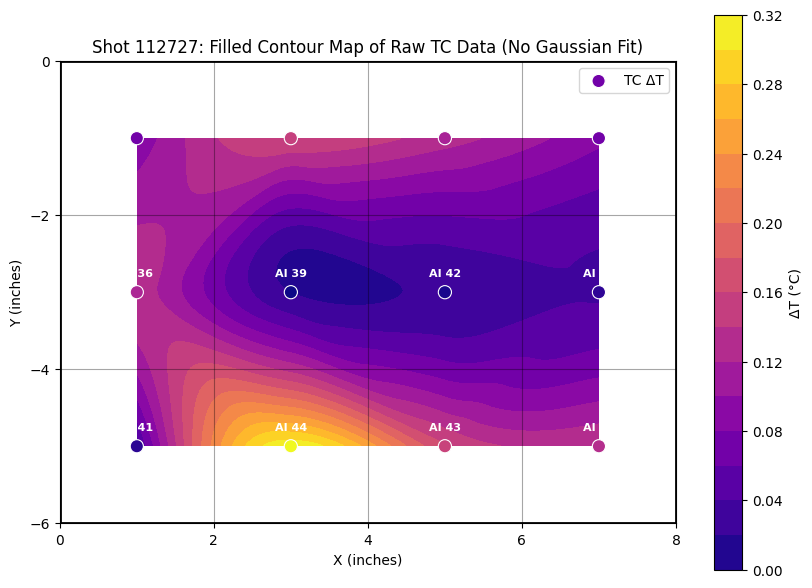

In [36]:
# Plot filled contour map of raw TC data (no Gaussian fitting)
from scipy.interpolate import griddata

if all_results:
    last_summary = all_results[-1]
    
    # Extract raw TC positions and ΔT values
    xdata = last_summary["X"].to_numpy()
    ydata = last_summary["Y"].to_numpy()
    zdata = last_summary["ΔT"].to_numpy()
    
    # Create interpolation grid
    Xgrid, Ygrid = np.meshgrid(np.linspace(0, 8, 160), np.linspace(-6, 0, 120))
    
    # Interpolate raw data onto grid
    # Use 'linear' for fewer points, 'cubic' for 4+ points
    interp_method = 'cubic' if len(xdata) >= 4 else 'linear'
    Zinterp = griddata((xdata, ydata), zdata, (Xgrid, Ygrid), method=interp_method)
    
    # Create filled contour plot
    fig3, ax3 = plt.subplots(figsize=(8.5, 6.0))
    
    levels = 15  # number of contour levels
    cf = ax3.contourf(Xgrid, Ygrid, Zinterp, levels=levels, cmap="plasma")
    cb = plt.colorbar(cf, ax=ax3, label="ΔT (°C)")
    
    # Overlay plate border (8×6 in)
    ax3.add_patch(Rectangle((0, -6), 8, 6, fill=False, linewidth=2, edgecolor="black", zorder=3))
    
    # Overlay 2×2″ grid lines
    for x in np.arange(0, 8.0001, 2.0):
        ax3.axvline(x, color="k", linewidth=0.8, alpha=0.35, zorder=3)
    for y in np.arange(-6, 0.0001, 2.0):
        ax3.axhline(y, color="k", linewidth=0.8, alpha=0.35, zorder=3)
    
    # TC points (measured ΔT) on top
    sc = ax3.scatter(xdata, ydata, c=zdata, cmap="plasma",
                    edgecolors="w", linewidths=0.8, s=90, zorder=4, label="TC ΔT")
    
    # TC labels
    for _, row in last_summary.iterrows():
        ax3.text(row["X"], row["Y"] + 0.18,
                row["Label"],
                ha="center", va="bottom", fontsize=8, color="white",
                weight="bold", zorder=5)
    
    # Axes cosmetics
    ax3.set_xlim(0, 8)
    ax3.set_ylim(-6, 0)
    ax3.set_aspect("equal", adjustable="box")
    ax3.set_xticks([0, 2, 4, 6, 8])
    ax3.set_yticks([0, -2, -4, -6])
    ax3.set_xlabel("X (inches)")
    ax3.set_ylabel("Y (inches)")
    
    shot_name = last_summary["Shot"].iloc[0]
    ax3.set_title(f"Shot {shot_name}: Filled Contour Map of Raw TC Data (No Gaussian Fit)")
    ax3.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot")